# Table of Contents

1) Imports and Setup
 - Loading files
 
2) COIL Data
 - Loads demo for duck task
 
3) Task 1: Can antGLasso recover video data?
 - Reproduces Figure 3 from paper
 
4) Task 2: Speed Graphs - Verify antGLasso is faster
 - Reproduces Figure 1 from paper
 
5) Task 3: Speed Graphs - Tensor data speed
 - Not in paper but results are referenced
 
6) Task 4: Precision-recall curves (for 10 sample and 50 sample case)
 - Reproduces Figure 2 from paper, and generalizes a bit
 
7) Task 5: Sparsity hyperparameters
 - Reproduces Figure 1 from supplementary material

# Imports and Setup

In [1]:
# Set import directory up right
import sys
sys.path.append('./Python Implementation')

# For reproducibility, these will display the package versions I'm using
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [2]:
# Import some standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image
import glob
import timeit
from cycler import cycler
from IPython.display import HTML

In [26]:
# And let's import code that we ourselves wrote
from Scripts.EiGLasso import EiGLasso
from Scripts.scBiGLasso import scBiGLasso
from Scripts.TeraLasso import TeraLasso
from Scripts.utilities import binarize_matrix, reconstruct_axes, shuffle_axes
from Scripts.antGLasso import antGLasso, antGLasso_heuristic, nmode_gram
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic
from Scripts.generate_data import generate_Ys
from Scripts.experiments import \
    create_precision_recall_curves_all, get_cms_for_betas_antGLasso, make_cm_plots_antGLasso, \
    create_precision_recall_curves_with_errorbars

In [4]:
# Will automatically update this notebook's imports if import source code is changed.
%load_ext autoreload
%autoreload 2

# COIL Data
From the dataset available here: https://cave.cs.columbia.edu/repository/COIL-20

Store the downloaded `coil-20-proc` directory as a subdirectory of `Data`, which should share a parent with this notebook (i.e. `./Data/coil-20-proc` should access the file contents).

In [104]:
%%capture
# Here we load the duck image.  In the BiGLasso paper, they considered 9 by 9
# pixel case with 36 frames.  Here, we consider the full 128x128x72 dataset.
# (The index of 10 is to grab the duck image)
import glob
def fix(x):
    # If filename contains single digit, append a 0
    if len(x.split('_')[-1].split('.')[0]) == 1:
        splate = x.split('_')
        splate[-1] = '0' + splate[-1]
        return '_'.join(splate)
    return x
globbed = glob.glob('./Data/coil-20-proc/*.png')
files = [(x, fix(x)) for x in globbed]
files.sort(key=lambda x:x[1])
duck_tens = np.array(
    [
        np.array(Image.open(f)).reshape(128**2)
        for f, _ in files
    ],
    dtype=np.int16
).reshape((20, 72, 128, 128))[10]
print(duck_tens.shape) # object, frame, flattened pixel

fig, ax = plt.subplots(figsize=(6, 6))
mat = ax.imshow(duck_tens[0].reshape(128, 128))
def update(idx):
    mat.set_data(duck_tens[idx].reshape(128, 128)) 
    return [mat]

anim = FuncAnimation(fig, update, frames=72, interval = 5, blit=True)

In [105]:
HTML(anim.to_jshtml(fps=20))

# Task 1: Can antGLasso recover video data?

In [6]:
mixed = shuffle_axes(duck_tens, axes=[0, 1, 2])

In [7]:
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic(mixed[np.newaxis, ...]),
    sparsities=[1, 1, 1],
    B_approx_iters=1000
)
_, order = reconstruct_axes(
    duck_tens[np.newaxis, ...],
    [1, 2, 3],
    Psis=Psis,
    return_order=True
)
unmixed = mixed[order[0]]
unmixed = unmixed[:, order[1]]
unmixed = unmixed[:, :, order[2]]

In [107]:
%%capture
with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 4))
    
    true_duckie = ax1.imshow(duck_tens[0])
    ax1.grid(False)
    ax1.axis('off')
    ax1.set_title('Truth')
    
    mixed_duckie = ax2.imshow(mixed[0])
    ax2.grid(False)
    ax2.axis('off')
    ax2.set_title('Shuffled')
    
    recovered_duckie = ax3.imshow(unmixed[0])
    ax3.grid(False)
    ax3.axis('off')
    ax3.set_title('Recovered')
    
    fig.suptitle(
        "(Shuffled data not animated as to spare the viewer from rapidly flashing lights)"
    )

    def update(idx):
        true_duckie.set_data(duck_tens[idx])
        mixed_duckie.set_data(mixed[0]) # Not animated in case anyone has trouble with flashes
        recovered_duckie.set_data(unmixed[idx])
        return [true_duckie, mixed_duckie, recovered_duckie]

    anim = FuncAnimation(fig, update, frames=mixed.shape[0], interval = 5, blit=True)

In [112]:
HTML(anim.to_jshtml(fps=20))
anim.save("Duck.gif", writer='imagemagick', fps=20)

MovieWriter imagemagick unavailable; using Pillow instead.


# Task 2: Speed Graphs - verify antGLasso is faster
Warning: Running these will take a decent chunk of time

In [10]:
def generate_timing_graph_smart(
    sizes,
    attempts, 
    m,
    df_scale,
    cutoff: "Amount of seconds before we stop considering it"=60,
    verbose=False
):
    include_sc = True
    include_eig = True
    include_tera = True
    include_ant = True
    include_ant_high_b = True
    times_sc = []
    times_eig = []
    times_tera = []
    times_ant = []
    times_ant_high_b = []
    for size in sizes:
        if verbose:
            print(f"Starting {size=}")
        if include_sc:
            times_sc.append(0)
        if include_eig:
            times_eig.append(0)
        if include_tera:
            times_tera.append(0)
        if include_ant:
            times_ant.append(0)
        if include_ant_high_b:
            times_ant_high_b.append(0)
        (Psi, Theta), Ys = generate_Ys(
            m=m,
            ds=[size, size],
            expected_nonzero=size**2 / 5,
            df_scale=df_scale
        )
        def time_scBiGLasso():
            scBiGLasso(
                N = 100,
                eps = 10e-4,
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                verbose = False
            )
        def time_EiGLasso():
            EiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01
            )
        def time_TeraLasso():
            TeraLasso(
                Ys,
                np.array(
                    [0.01, 0.01],
                    dtype=np.float64
                )
            )
        def time_antGLasso():
            antGLasso(
                Ys = Ys,
                betas = [0.01, 0.01],
                B_approx_iters = 10
            )
        def time_antGLasso_high_b():
            antGLasso(
                Ys = Ys,
                betas = [0.01, 0.01],
                B_approx_iters = 1000
            )
        if include_sc:
            timer = timeit.Timer(time_scBiGLasso)
            times_sc[-1] = timer.timeit(attempts) / attempts
            if times_sc[-1] >= cutoff:
                include_sc = False
        if include_eig:
            timer = timeit.Timer(time_EiGLasso)
            times_eig[-1] = timer.timeit(attempts) / attempts
            if times_eig[-1] >= cutoff:
                include_eig = False
        if include_tera:
            timer = timeit.Timer(time_TeraLasso)
            times_tera[-1] = timer.timeit(attempts) / attempts
            if times_tera[-1] >= cutoff:
                include_tera = False
        if include_ant:
            timer = timeit.Timer(time_antGLasso)
            times_ant[-1] = timer.timeit(attempts) / attempts
            if times_ant[-1] >= cutoff:
                include_ant = False
        if include_ant_high_b:
            timer = timeit.Timer(time_antGLasso_high_b)
            times_ant_high_b[-1] = timer.timeit(attempts) / attempts
            if times_ant_high_b[-1] >= cutoff:
                include_ant_high_b = False
        if verbose:
            print(
                (f"\n\tSc : {times_sc[-1]} Seconds" if include_sc else "")
                + (f"\n\tAnt (b=10): {times_ant[-1]} Seconds" if include_ant else "")
                + (f"\n\tAnt (b=1000): {times_ant_high_b[-1]} Seconds" 
                   if include_ant_high_b else "")
                + (f"\n\tEig : {times_eig[-1]} Seconds" if include_eig else "")
                + (f"\n\tTera : {times_tera[-1]} Seconds" if include_tera else "")
            )
    print("Done")
    return times_sc, times_ant, times_ant_high_b, times_eig, times_tera

In [11]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'hard' distribution")
sizes_for_hard_small = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500,
    600, 700, 800, 900, 1000,
    1250, 1500, 1750, 2000,
    2500, 3000, 3500, 4000,
    4500, 5000
]
sc_hard_small, ant_hard_small, ant_b_hard_small, eig_hard_small, tera_hard_small = \
    generate_timing_graph_smart(
        sizes_for_hard_small,
        attempts,
        df_scale=1,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'hard' distribution
Starting size=20

	Sc : 2.688380125000002 Seconds
	Ant (b=10): 0.06029187499999722 Seconds
	Ant (b=1000): 0.1839965419999956 Seconds
	Eig : 1.8824805839999996 Seconds
	Tera : 0.9645246659999991 Seconds
Starting size=40

	Sc : 14.345672915999998 Seconds
	Ant (b=10): 0.008752874999998994 Seconds
	Ant (b=1000): 0.17341479200000265 Seconds
	Eig : 1.3368056660000036 Seconds
	Tera : 0.6532459579999994 Seconds
Starting size=60

	Sc : 39.495608583000006 Seconds
	Ant (b=10): 0.021611417000002575 Seconds
	Ant (b=1000): 0.1882045409999904 Seconds
	Eig : 2.6190955000000002 Seconds
	Tera : 1.443806125000009 Seconds
Starting size=80

	Ant (b=10): 0.029802958000004764 Seconds
	Ant (b=1000): 0.2368247920000215 Seconds
	Eig : 9.050876750000015 Seconds
	Tera : 1.9228154159999917 Seconds
Starting size=100

	Ant (b=10): 0.017342708999990464 Seconds
	Ant (b=1000): 0.18932874999998717 Seconds
	Eig : 6.47957120800001 Seconds
	Tera : 2.9932857910000052 Seconds
Start

In [12]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'easy' distribution")
sizes_for_easy_small = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500,
    600, 700, 800, 900, 1000,
    1250, 1500, 1750, 2000,
    2500, 3000, 3500, 4000,
    4500, 5000
]
sc_easy_small, ant_easy_small, ant_b_easy_small, eig_easy_small, tera_easy_small = \
    generate_timing_graph_smart(
        sizes_for_easy_small,
        attempts,
        df_scale=2,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'easy' distribution
Starting size=20

	Sc : 5.283489624999902 Seconds
	Ant (b=10): 0.06904174999999668 Seconds
	Ant (b=1000): 0.18362133400000857 Seconds
	Eig : 0.27848562500003027 Seconds
	Tera : 0.9871518330000981 Seconds
Starting size=40

	Sc : 28.680915666000146 Seconds
	Ant (b=10): 0.007828499999959604 Seconds
	Ant (b=1000): 0.16939237499991577 Seconds
	Eig : 0.15951337499996043 Seconds
	Tera : 0.47649362500010284 Seconds
Starting size=60

	Ant (b=10): 0.04580354199993053 Seconds
	Ant (b=1000): 0.17857616700007384 Seconds
	Eig : 0.3916081669999585 Seconds
	Tera : 1.053464083000108 Seconds
Starting size=80

	Ant (b=10): 0.03143129200020667 Seconds
	Ant (b=1000): 0.18635729199991147 Seconds
	Eig : 2.4763301670000146 Seconds
	Tera : 1.6261615000000802 Seconds
Starting size=100

	Ant (b=10): 0.016519333999895025 Seconds
	Ant (b=1000): 0.19464754099999482 Seconds
	Eig : 1.0012905839998893 Seconds
	Tera : 2.1289910830000736 Seconds
Starting size=125

	Ant (b=10):

In [13]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a large-sample 'hard' distribution")
sizes_for_hard_large = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500
]
sc_hard_large, ant_hard_large, ant_b_hard_large, eig_hard_large, tera_hard_large = \
    generate_timing_graph_smart(
        sizes_for_hard_large,
        attempts,
        df_scale=1,
        m=100,
        cutoff=60,
        verbose=True
    )

Times on a large-sample 'hard' distribution
Starting size=20

	Sc : 4.890577334000227 Seconds
	Ant (b=10): 0.024810625000100117 Seconds
	Ant (b=1000): 0.1717322909998984 Seconds
	Eig : 0.1840465000000222 Seconds
	Tera : 1.3490510830001767 Seconds
Starting size=40

	Sc : 25.928679041000123 Seconds
	Ant (b=10): 0.02055520899966723 Seconds
	Ant (b=1000): 0.17023129199969844 Seconds
	Eig : 0.0500649999999041 Seconds
	Tera : 0.39535029099988606 Seconds
Starting size=60

	Ant (b=10): 0.03268420799986416 Seconds
	Ant (b=1000): 0.24735899999996036 Seconds
	Eig : 0.14957795800000895 Seconds
	Tera : 1.0767048749999049 Seconds
Starting size=80

	Ant (b=10): 0.2811020409999401 Seconds
	Ant (b=1000): 0.284976375000042 Seconds
	Eig : 0.16076212499956455 Seconds
	Tera : 1.9013454579999234 Seconds
Starting size=100

	Ant (b=10): 0.15091191700003037 Seconds
	Ant (b=1000): 0.41026658400005545 Seconds
	Eig : 0.4462324159999298 Seconds
	Tera : 2.8753825829999187 Seconds
Starting size=125

	Ant (b=10): 0.1

In [14]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a large-sample 'easy' distribution")
sizes_for_easy_large = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500
]
sc_easy_large, ant_easy_large, ant_b_easy_large, eig_easy_large, tera_easy_large = \
    generate_timing_graph_smart(
        sizes_for_easy_large,
        attempts,
        df_scale=2,
        m=100,
        cutoff=60,
        verbose=True
    )

Times on a large-sample 'easy' distribution
Starting size=20

	Sc : 0.10548883299998124 Seconds
	Ant (b=10): 0.006794999999783613 Seconds
	Ant (b=1000): 0.1702655830004005 Seconds
	Eig : 0.009914582999954291 Seconds
	Tera : 0.07623616699993363 Seconds
Starting size=40

	Sc : 0.3598205829998733 Seconds
	Ant (b=10): 0.00944104200016227 Seconds
	Ant (b=1000): 0.1880194999998821 Seconds
	Eig : 0.01645787500001461 Seconds
	Tera : 0.13471800000024814 Seconds
Starting size=60

	Sc : 0.9012276659996132 Seconds
	Ant (b=10): 0.045930499999940366 Seconds
	Ant (b=1000): 0.19241495900041627 Seconds
	Eig : 0.03667070799974681 Seconds
	Tera : 0.2703557920003732 Seconds
Starting size=80

	Sc : 0.6680337910001981 Seconds
	Ant (b=10): 0.04874104199961948 Seconds
	Ant (b=1000): 0.21358795799960717 Seconds
	Eig : 0.0861454999999296 Seconds
	Tera : 0.36238829200010514 Seconds
Starting size=100

	Sc : 1.835356665999825 Seconds
	Ant (b=10): 0.13110904199993456 Seconds
	Ant (b=1000): 0.2594956660000207 Second

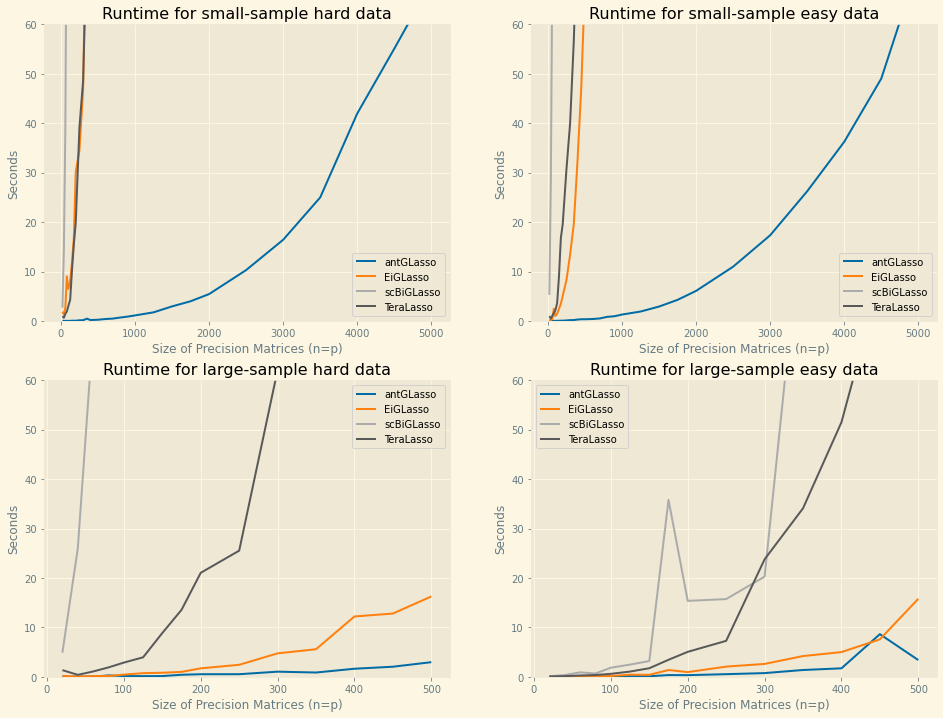

In [15]:
with plt.style.context('Solarize_Light2'):
        plt.rcParams['axes.prop_cycle'] = cycler(color=[
            '#006BA4',
            '#FF800E',
            '#ABABAB',
            '#595959',
            '#5F9ED1',
            '#C85200',
            '#898989',
            '#A2C8EC',
            '#FFBC79',
            '#CFCFCF'
        ])
        fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(16, 12), nrows=2, ncols=2)
        ax1.plot(
            sizes_for_hard_small[:len(ant_hard_small)],
            ant_hard_small,
            label='antGLasso'
        )
        ax1.plot(
            sizes_for_hard_small[:len(eig_hard_small)],
            eig_hard_small,
            label='EiGLasso'
        )
        ax1.plot(sizes_for_hard_small[:len(sc_hard_small)],
                 sc_hard_small,
                 label='scBiGLasso'
        )
        ax1.plot(sizes_for_hard_small[:len(tera_hard_small)],
                 tera_hard_small,
                 label='TeraLasso'
        )
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for small-sample hard data")
        ax1.set_ylim([0, 60])
        ax1.legend()
        
        ax2.plot(
            sizes_for_easy_small[:len(ant_easy_small)],
            ant_easy_small,
            label='antGLasso'
        )
        ax2.plot(
            sizes_for_easy_small[:len(eig_easy_small)],
            eig_easy_small,
            label='EiGLasso'
        )
        ax2.plot(sizes_for_easy_small[:len(sc_easy_small)],
                 sc_easy_small,
                 label='scBiGLasso'
        )
        ax2.plot(sizes_for_easy_small[:len(tera_easy_small)],
                 tera_easy_small,
                 label='TeraLasso'
        )
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for small-sample easy data")
        ax2.set_ylim([0, 60])
        ax2.legend()
        
        ax3.plot(
            sizes_for_hard_large[:len(ant_hard_large)],
            ant_hard_large,
            label='antGLasso'
        )
        ax3.plot(
            sizes_for_hard_large[:len(eig_hard_large)],
            eig_hard_large,
            label='EiGLasso'
        )
        ax3.plot(sizes_for_hard_large[:len(sc_hard_large)],
                 sc_hard_large,
                 label='scBiGLasso'
        )
        ax3.plot(sizes_for_hard_large[:len(tera_hard_large)],
                 tera_hard_large,
                 label='TeraLasso'
        )
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_title(f"Runtime for large-sample hard data")
        ax3.set_ylim([0, 60])
        ax3.legend()
        
        ax4.plot(
            sizes_for_easy_large[:len(ant_easy_large)],
            ant_easy_large,
            label='antGLasso'
        )
        ax4.plot(
            sizes_for_easy_large[:len(eig_easy_large)],
            eig_easy_large,
            label='EiGLasso'
        )
        ax4.plot(sizes_for_easy_large[:len(sc_easy_large)],
                 sc_easy_large,
                 label='scBiGLasso'
        )
        ax4.plot(sizes_for_easy_large[:len(tera_easy_large)],
                 tera_easy_large,
                 label='TeraLasso'
        )
        ax4.set_xlabel("Size of Precision Matrices (n=p)")
        ax4.set_ylabel("Seconds")
        ax4.set_title(f"Runtime for large-sample easy data")
        ax4.set_ylim([0, 60])
        ax4.legend()

# Task 3: Speed Graphs - Tensor Data Speed

In [16]:
def generate_timing_graph_tensor(
    sizes,
    attempts, 
    m,
    df_scale,
    num_dims,
    cutoff: "Amount of seconds before we stop considering it"=60,
    verbose=False,
):
    include_tera = True
    include_ant = True
    include_ant_high_b = True
    times_tera = []
    times_ant = []
    times_ant_high_b = []
    for size in sizes:
        if verbose:
            print(f"Starting {size=}")
        if include_tera:
            times_tera.append(0)
        if include_ant:
            times_ant.append(0)
        if include_ant_high_b:
            times_ant_high_b.append(0)
        _, Ys = generate_Ys(
            m=m,
            ds=(ds:=[size]*num_dims),
            expected_nonzero=size**2 / 5,
            df_scale=df_scale
        )
        def time_TeraLasso():
            TeraLasso(
                Ys,
                np.array(
                    [0.01]*num_dims,
                    dtype=np.float64
                )
            )
        def time_antGLasso():
            antGLasso(
                Ys = Ys,
                betas = [0.01]*num_dims,
                B_approx_iters = 10
            )
        def time_antGLasso_high_b():
            antGLasso(
                Ys = Ys,
                betas = [0.01]*num_dims,
                B_approx_iters = 1000
            )
        if include_tera:
            timer = timeit.Timer(time_TeraLasso)
            times_tera[-1] = timer.timeit(attempts) / attempts
            if times_tera[-1] >= cutoff:
                include_tera = False
        if include_ant:
            timer = timeit.Timer(time_antGLasso)
            times_ant[-1] = timer.timeit(attempts) / attempts
            if times_ant[-1] >= cutoff:
                include_ant = False
        if include_ant_high_b:
            timer = timeit.Timer(time_antGLasso_high_b)
            times_ant_high_b[-1] = timer.timeit(attempts) / attempts
            if times_ant_high_b[-1] >= cutoff:
                include_ant = False
        if verbose:
            print(
                (f"\n\tAnt (b=10): {times_ant[-1]} Seconds" if include_ant else "")
                + (f"\n\tAnt (b=1000): {times_ant_high_b[-1]} Seconds"
                   if include_ant_high_b else "")
                + (f"\n\tTera : {times_tera[-1]} Seconds" if include_tera else "")
            )
    print("Done")
    return times_ant, times_ant_high_b, times_tera

In [17]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'hard' distribution")
sizes_for_hard_small_tensor = [
    20, 40, 60, 80, 100, 120, 140, 160, 180, 200,
    220, 240, 260, 280, 300
]
ant_hard_small_tensor, ant_high_b_hard_small_tensor, tera_hard_small_tensor = \
    generate_timing_graph_tensor(
        sizes_for_hard_small_tensor,
        attempts,
        num_dims=3,
        df_scale=1,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'hard' distribution
Starting size=20

	Ant (b=10): 0.012090207999790437 Seconds
	Ant (b=1000): 0.21986283399974127 Seconds
	Tera : 1.511631374999979 Seconds
Starting size=40

	Ant (b=10): 0.011578457999803504 Seconds
	Ant (b=1000): 0.23263429200005703 Seconds
	Tera : 0.8481341669998983 Seconds
Starting size=60

	Ant (b=10): 0.056214458999875205 Seconds
	Ant (b=1000): 0.26785300000028656 Seconds
	Tera : 1.92234954200012 Seconds
Starting size=80

	Ant (b=10): 0.6050767079996149 Seconds
	Ant (b=1000): 0.5541504170000735 Seconds
	Tera : 4.370309166999959 Seconds
Starting size=100

	Ant (b=10): 0.34684500000003027 Seconds
	Ant (b=1000): 0.753423790999932 Seconds
	Tera : 6.0198661659997015 Seconds
Starting size=120

	Ant (b=10): 0.6787539580000157 Seconds
	Ant (b=1000): 0.578630874999817 Seconds
	Tera : 8.75233441599994 Seconds
Starting size=140

	Ant (b=10): 0.6384467500001847 Seconds
	Ant (b=1000): 0.7577047909999237 Seconds
	Tera : 18.63564791600038 Seconds
Startin

In [18]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'easy' distribution")
sizes_for_easy_small_tensor = [
    20, 40, 60, 80, 100, 120, 140, 160, 180, 200,
    220, 240, 260, 280, 300
]
ant_easy_small_tensor, ant_high_b_easy_small_tensor, tera_easy_small_tensor = \
    generate_timing_graph_tensor(
        sizes_for_easy_small_tensor,
        attempts,
        num_dims=3,
        df_scale=2,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'easy' distribution
Starting size=20

	Ant (b=10): 0.016088416000002326 Seconds
	Ant (b=1000): 0.26806212500014226 Seconds
	Tera : 1.524877708999611 Seconds
Starting size=40

	Ant (b=10): 0.019117791999633482 Seconds
	Ant (b=1000): 0.2761196250003195 Seconds
	Tera : 0.5197318749997066 Seconds
Starting size=60

	Ant (b=10): 0.04914187500025946 Seconds
	Ant (b=1000): 0.2551392919999671 Seconds
	Tera : 0.6292303330001232 Seconds
Starting size=80

	Ant (b=10): 0.13742029199966055 Seconds
	Ant (b=1000): 0.3525496669999484 Seconds
	Tera : 1.1660518749999937 Seconds
Starting size=100

	Ant (b=10): 0.6384596249999959 Seconds
	Ant (b=1000): 0.5727892919999249 Seconds
	Tera : 1.7639177080000081 Seconds
Starting size=120

	Ant (b=10): 0.3308868750000329 Seconds
	Ant (b=1000): 0.5494781659999717 Seconds
	Tera : 1.8330947499998729 Seconds
Starting size=140

	Ant (b=10): 0.7264827919998424 Seconds
	Ant (b=1000): 0.8132751670000289 Seconds
	Tera : 3.346241249999821 Seconds
Sta

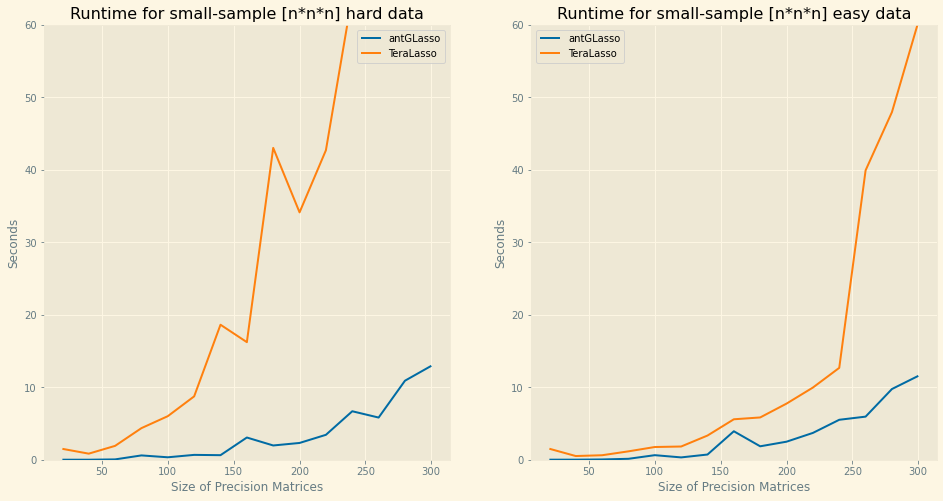

In [19]:
with plt.style.context('Solarize_Light2'):
        plt.rcParams['axes.prop_cycle'] = cycler(color=[
            '#006BA4',
            '#FF800E',
            '#ABABAB',
            '#595959',
            '#5F9ED1',
            '#C85200',
            '#898989',
            '#A2C8EC',
            '#FFBC79',
            '#CFCFCF'
        ])
        fig1, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)
        ax1.plot(
            sizes_for_hard_small_tensor[:len(ant_hard_small_tensor)],
            ant_hard_small_tensor,
            label='antGLasso'
        )
        ax1.plot(sizes_for_hard_small_tensor[:len(tera_hard_small_tensor)],
                 tera_hard_small_tensor,
                 label='TeraLasso'
        )
        ax1.set_xlabel("Size of Precision Matrices")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for small-sample [n*n*n] hard data")
        ax1.set_ylim([0, 60])
        ax1.legend()
        
        ax2.plot(
            sizes_for_easy_small_tensor[:len(ant_easy_small_tensor)],
            ant_easy_small_tensor,
            label='antGLasso'
        )
        ax2.plot(sizes_for_easy_small_tensor[:len(tera_easy_small_tensor)],
                 tera_easy_small_tensor,
                 label='TeraLasso'
        )
        ax2.set_xlabel("Size of Precision Matrices")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for small-sample [n*n*n] easy data")
        ax2.set_ylim([0, 60])
        ax2.legend()

# Task 4: Precision-Recall Curves
Warning: code here may take a while to run too.

## 10 samples of 50x50

Trying algorithm: antGLasso
	Trying beta=0.000100
	Trying beta=0.000158
	Trying beta=0.000251
	Trying beta=0.000398
	Trying beta=0.000631
	Trying beta=0.001000
	Trying beta=0.001585
	Trying beta=0.002512
	Trying beta=0.003981
	Trying beta=0.006310
	Trying beta=0.010000
	Trying beta=0.015849
	Trying beta=0.025119
	Trying beta=0.039811
	Trying beta=0.063096
	Trying beta=0.100000
	Trying beta=0.158489
	Trying beta=0.251189
	Trying beta=0.398107
	Trying beta=0.630957
Trying algorithm: TeraLasso
	Trying beta=0.000100
	Trying beta=0.000158
	Trying beta=0.000251
	Trying beta=0.000398
	Trying beta=0.000631
	Trying beta=0.001000
	Trying beta=0.001585
	Trying beta=0.002512
	Trying beta=0.003981
	Trying beta=0.006310
	Trying beta=0.010000
	Trying beta=0.015849
	Trying beta=0.025119
	Trying beta=0.039811
	Trying beta=0.063096
	Trying beta=0.100000
	Trying beta=0.158489
	Trying beta=0.251189
	Trying beta=0.398107
	Trying beta=0.630957
Trying algorithm: scBiGLasso
	Trying beta=0.100000
	Trying beta=

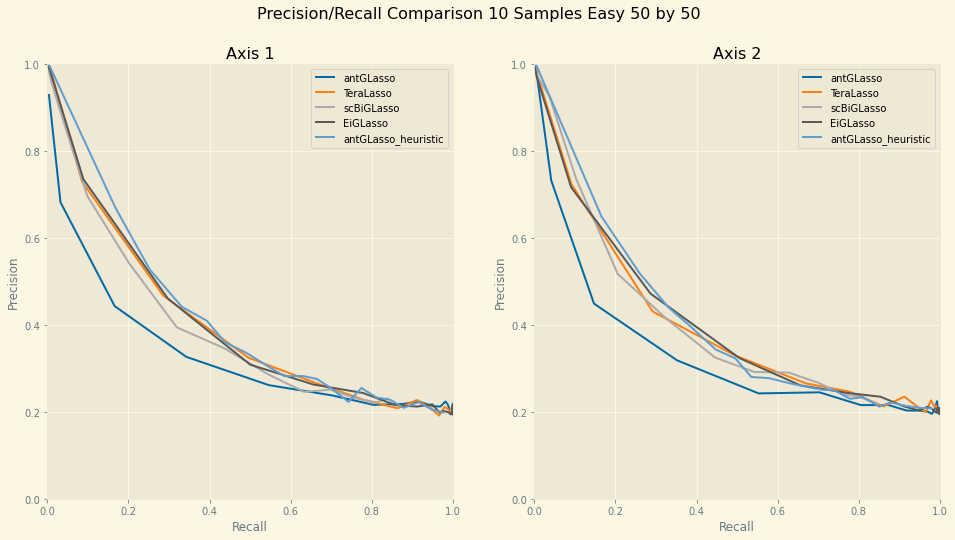

In [123]:
fig, axs, _ = create_precision_recall_curves_with_errorbars(
    betas_to_try=np.array([
        10**np.arange(-4, 0, 0.2), #ant
        10**np.arange(-4, 0, 0.2), #Tera
        10**np.arange(-1, 1, 0.1), #sc
        10**np.arange(-4, 0, 0.2), #EiG
        np.arange(0, 1., 0.05) #ant_heur
    ]),
    algorithms=[
        "antGLasso",
        "TeraLasso",
        "scBiGLasso",
        "EiGLasso",
        "antGLasso_heuristic"
    ],
    omit_errorbars_from=[
        "TeraLasso",
        "scBiGLasso",
        "antGLasso_heuristic",
        "antGLasso",
        "EiGLasso"
    ],
    m=10,
    ds=[50, 50],
    attempts=50,
    df_scale=2,
    cm_mode="Nonzero",
    title="Precision/Recall Comparison 10 Samples Easy 50 by 50",
    verbose=True
)

In [124]:
fig.savefig("10 Samples 50x50.svg")

## 50 Samples of 50x50

Trying algorithm: antGLasso
	Trying beta=0.000100
	Trying beta=0.000158
	Trying beta=0.000251
	Trying beta=0.000398
	Trying beta=0.000631
	Trying beta=0.001000
	Trying beta=0.001585
	Trying beta=0.002512
	Trying beta=0.003981
	Trying beta=0.006310
	Trying beta=0.010000
	Trying beta=0.015849
	Trying beta=0.025119
	Trying beta=0.039811
	Trying beta=0.063096
	Trying beta=0.100000
	Trying beta=0.158489
	Trying beta=0.251189
	Trying beta=0.398107
	Trying beta=0.630957
Trying algorithm: TeraLasso
	Trying beta=0.000100
	Trying beta=0.000158
	Trying beta=0.000251
	Trying beta=0.000398
	Trying beta=0.000631
	Trying beta=0.001000
	Trying beta=0.001585
	Trying beta=0.002512
	Trying beta=0.003981
	Trying beta=0.006310
	Trying beta=0.010000
	Trying beta=0.015849
	Trying beta=0.025119
	Trying beta=0.039811
	Trying beta=0.063096
	Trying beta=0.100000
	Trying beta=0.158489
	Trying beta=0.251189
	Trying beta=0.398107
	Trying beta=0.630957
Trying algorithm: scBiGLasso
	Trying beta=0.100000
	Trying beta=

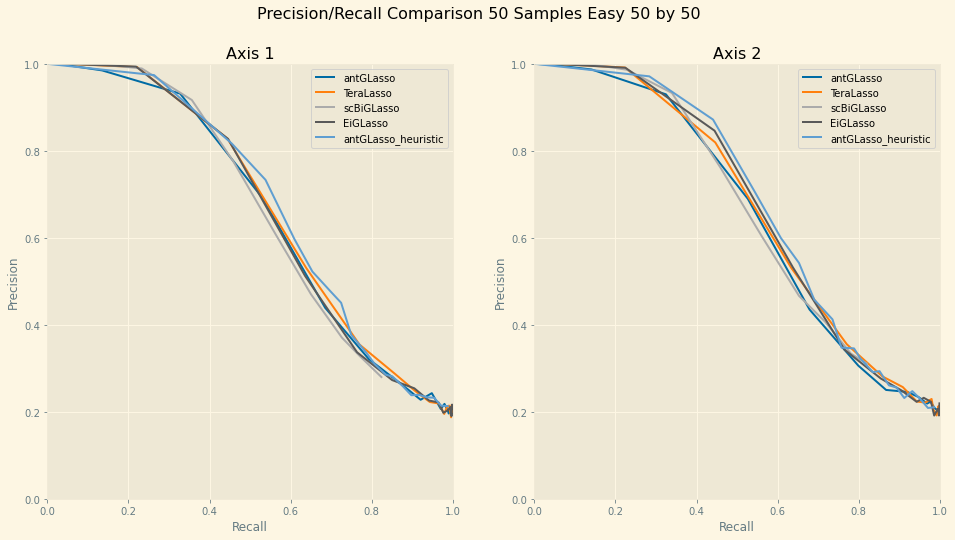

In [125]:
fig, axs, _ = create_precision_recall_curves_with_errorbars(
    betas_to_try=np.array([
        10**np.arange(-4, 0, 0.2), #ant
        10**np.arange(-4, 0, 0.2), #Tera
        10**np.arange(-1, 1, 0.1), #sc
        10**np.arange(-4, 0, 0.2), #EiG
        np.arange(0, 1., 0.05) #ant_heur
    ]),
    algorithms=[
        "antGLasso",
        "TeraLasso",
        "scBiGLasso",
        "EiGLasso",
        "antGLasso_heuristic"
    ],
    omit_errorbars_from=[
        "TeraLasso",
        "scBiGLasso",
        "antGLasso_heuristic",
        "antGLasso",
        "EiGLasso"
    ],
    m=50,
    ds=[50, 50],
    attempts=50,
    df_scale=2,
    cm_mode="Nonzero",
    title="Precision/Recall Comparison 50 Samples Easy 50 by 50",
    verbose=True
)

In [126]:
fig.savefig("50 Samples 50x50.svg")

# Task 5: Sparsity Hyperparameters

	Trying beta=0.000000
	Trying beta=0.050000
	Trying beta=0.100000
	Trying beta=0.150000
	Trying beta=0.200000
	Trying beta=0.250000
	Trying beta=0.300000
	Trying beta=0.350000
	Trying beta=0.400000
	Trying beta=0.450000
	Trying beta=0.500000
	Trying beta=0.550000
	Trying beta=0.600000
	Trying beta=0.650000
	Trying beta=0.700000
	Trying beta=0.750000
	Trying beta=0.800000
	Trying beta=0.850000
	Trying beta=0.900000
	Trying beta=0.950000


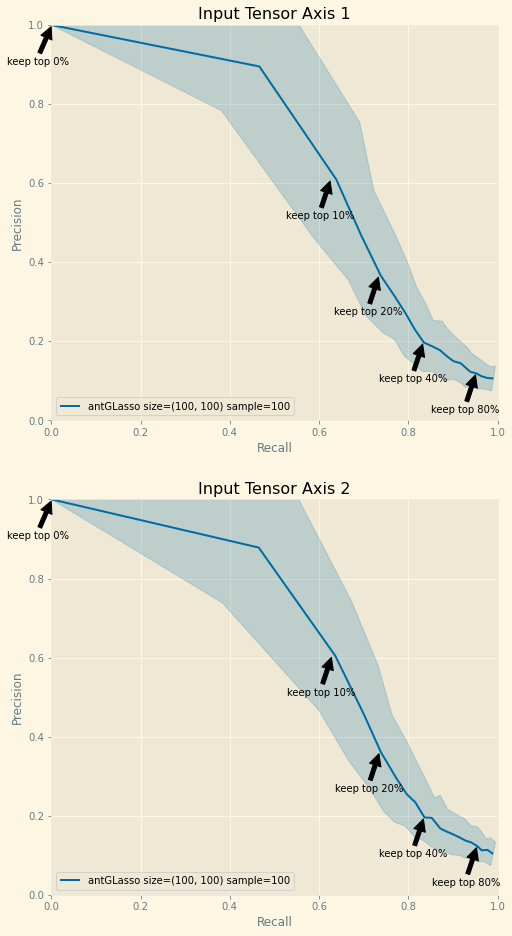

In [113]:
# 10% Edges Kept
data_out = get_cms_for_betas_antGLasso(
    betas_to_try=(betas_to_try:=np.array([
        np.arange(0., 1, 0.05), #Size 100 Sample 100
    ])),
    attempts=100,
    cm_mode="Nonzero",
    verbose=True,
    sizes=[(100, 100)],
    samples=[100],
    try_sparsities=True,
    sparsity=0.1
)
fig, _ = make_cm_plots_antGLasso(
    Psis_cms=data_out,
    sizes=[(100, 100)],
    samples=[100],
    betas_to_highlight=[[0, 2, 4, 8, 16]],
    betas=betas_to_try
)

In [117]:
fig.savefig("sparsity 10% with error bars.svg", bbox_inches='tight')

	Trying beta=0.000000
	Trying beta=0.050000
	Trying beta=0.100000
	Trying beta=0.150000
	Trying beta=0.200000
	Trying beta=0.250000
	Trying beta=0.300000
	Trying beta=0.350000
	Trying beta=0.400000
	Trying beta=0.450000
	Trying beta=0.500000
	Trying beta=0.550000
	Trying beta=0.600000
	Trying beta=0.650000
	Trying beta=0.700000
	Trying beta=0.750000
	Trying beta=0.800000
	Trying beta=0.850000
	Trying beta=0.900000
	Trying beta=0.950000


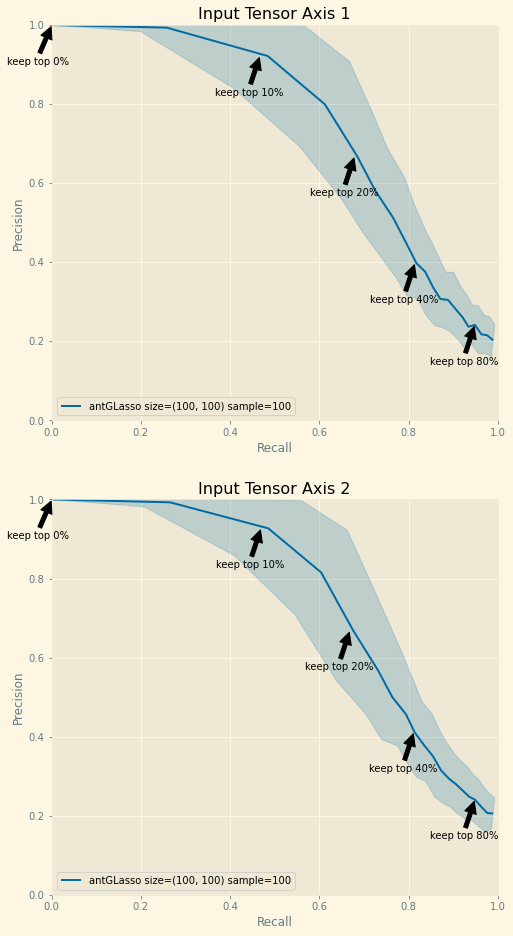

In [118]:
# 20% Edges Kept
data_out = get_cms_for_betas_antGLasso(
    betas_to_try=(betas_to_try:=np.array([
        np.arange(0., 1, 0.05), #Size 100 Sample 100
    ])),
    attempts=100,
    cm_mode="Nonzero",
    verbose=True,
    sizes=[(100, 100)],
    samples=[100],
    try_sparsities=True,
    sparsity=0.2
)
fig, _ = make_cm_plots_antGLasso(
    Psis_cms=data_out,
    sizes=[(100, 100)],
    samples=[100],
    betas_to_highlight=[[0, 2, 4, 8, 16]],
    betas=betas_to_try
)

In [119]:
fig.savefig("sparsity 20% with error bars.svg", bbox_inches='tight')

	Trying beta=0.000000
	Trying beta=0.050000
	Trying beta=0.100000
	Trying beta=0.150000
	Trying beta=0.200000
	Trying beta=0.250000
	Trying beta=0.300000
	Trying beta=0.350000
	Trying beta=0.400000
	Trying beta=0.450000
	Trying beta=0.500000
	Trying beta=0.550000
	Trying beta=0.600000
	Trying beta=0.650000
	Trying beta=0.700000
	Trying beta=0.750000
	Trying beta=0.800000
	Trying beta=0.850000
	Trying beta=0.900000
	Trying beta=0.950000


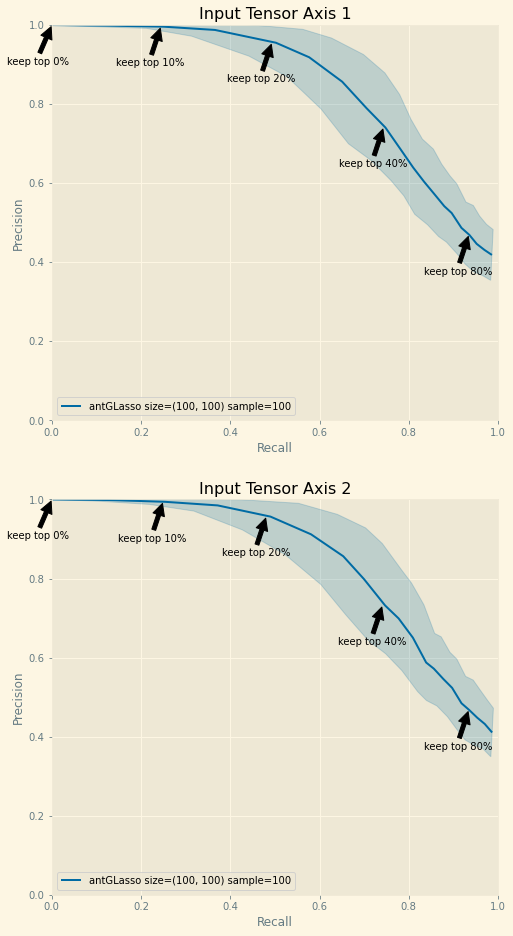

In [120]:
# 40% Edges Kept
data_out = get_cms_for_betas_antGLasso(
    betas_to_try=(betas_to_try:=np.array([
        np.arange(0., 1, 0.05), #Size 100 Sample 100
    ])),
    attempts=100,
    cm_mode="Nonzero",
    verbose=True,
    sizes=[(100, 100)],
    samples=[100],
    try_sparsities=True,
    sparsity=0.4
)
fig, _ = make_cm_plots_antGLasso(
    Psis_cms=data_out,
    sizes=[(100, 100)],
    samples=[100],
    betas_to_highlight=[[0, 2, 4, 8, 16]],
    betas=betas_to_try
)

In [121]:
fig.savefig("sparsity 40% with error bars.svg", bbox_inches="tight")